In [134]:
from os.path import join

import einops
import mne
import torch
from datasets.deap import DEAPDataset
from datasets.eeg_emrec import EEGClassificationDataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [116]:
dataset: EEGClassificationDataset = DEAPDataset(
    path=join("..", "..", "..", "datasets", "eeg_emotion_recognition", "deap"),
    split_in_windows=True,
    window_size=1,
    drop_last=True,
    discretize_labels=True,
    normalize_eegs=True,
)

In [136]:
sample = dataset[0]["eegs"] * 1e6
print(sample.shape)

torch.Size([128, 32])


Opening raw-browser...


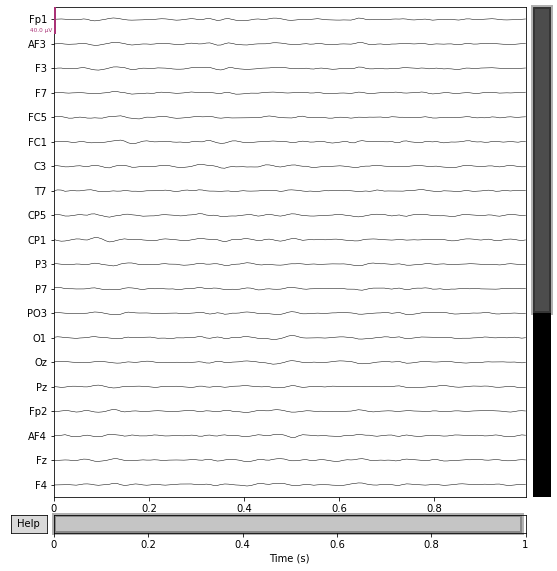

In [118]:
def plot_eeg_sample(sample: torch.Tensor):
    a = mne.io.RawArray(data=einops.rearrange(sample, "s c -> c s"),
                        info=mne.create_info(
                            ch_names=dataset.electrodes,
                            sfreq=dataset.sampling_rate,
                            ch_types="eeg",
                            verbose=False, ),
                        verbose=False,
                        )
    a.plot()


plot_eeg_sample(sample)

In [119]:
from torchaudio import transforms

window_size = int(dataset.sampling_rate * 0.1)
window_stride = int(dataset.sampling_rate * 0.05)
print(window_size, window_stride)

mel_fn = transforms.MelSpectrogram(
    sample_rate=dataset.sampling_rate,
    f_min=0, f_max=50,
    n_mels=8,
    center=True,
    n_fft=window_size,
    normalized=False,
    power=2,
    win_length=window_size,
    hop_length=window_stride,
    # pad=self.window_stride // 2,
    pad=0,
)
spectrogram = mel_fn(sample[:, 0])  # (b c m s)
print(sample.shape, spectrogram.shape)
# einops.rearrange(mel_fn(sample), "s ")

12 6
torch.Size([128, 32]) torch.Size([8, 22])


# Type of spectrograms

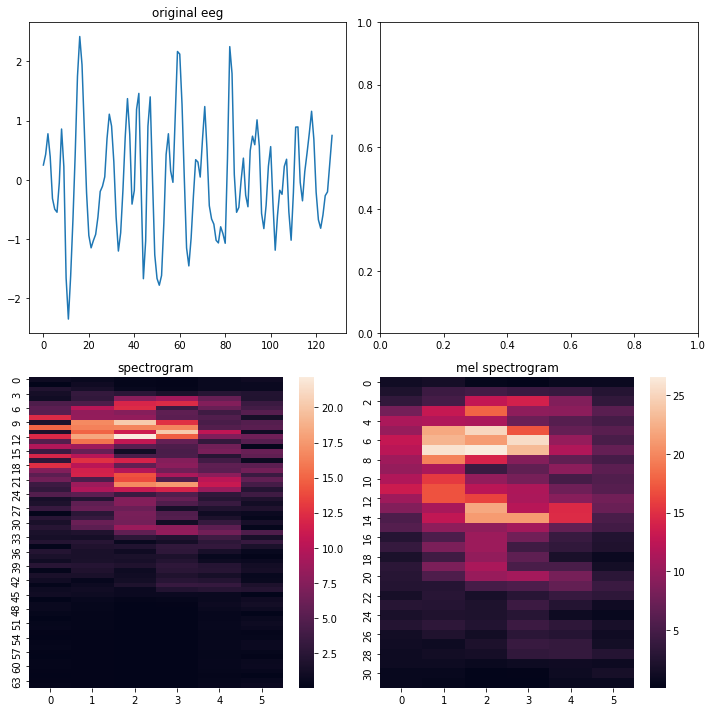

In [139]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(5*2, 5*2))
axs[0, 0].plot(sample[:, 0])
axs[0, 0].set_title("original eeg")

# standard
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mel_fn = transforms.Spectrogram(
        # sample_rate=dataset.sampling_rate,
        # f_min=0, f_max=50,
        # n_mels=32,
        center=True,
        n_fft=128,
        normalized=False,
        power=1,
        win_length=window_size,
        hop_length=window_stride,
        pad=window_stride // 2,
        # pad=0,
    )
    spectrogram = mel_fn(sample[:, 0])  # (m s)
    # spectrogram = 20 * torch.log10(spectrogram/1e-5)
sns.heatmap(spectrogram, ax=axs[1, 0])
axs[1, 0].set_title(f"spectrogram")

# mel spectrogram
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mel_fn = transforms.MelSpectrogram(
        sample_rate=dataset.sampling_rate,
        f_min=0, f_max=50,
        n_mels=32,
        center=True,
        n_fft=128,
        normalized=False,
        power=1,
        win_length=window_size,
        hop_length=window_stride,
        pad=window_stride // 2,
        # pad=0,
    )
    spectrogram = mel_fn(sample[:, 0])  # (m s)
    # spectrogram = 20 * torch.log10(spectrogram/1e-5)
sns.heatmap(spectrogram, ax=axs[1, 1])
axs[1, 1].set_title(f"mel spectrogram")

plt.show()

# Normalization

/home/rom42pla/anaconda3/envs/eeg_emrec/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (32) may be set too high. Or, the value for `n_freqs` (7) may be set too low.
  warnings.warn(


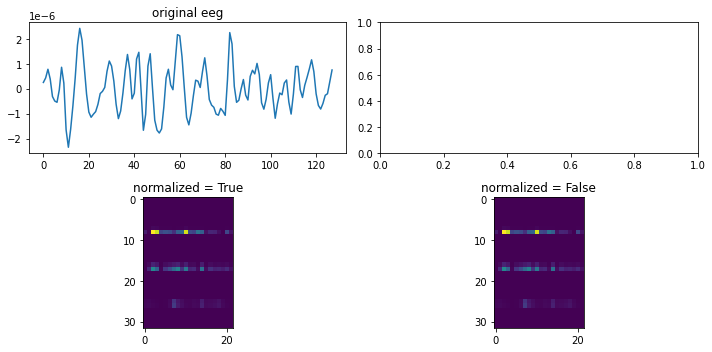

In [120]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 5))
axs[0, 0].plot(sample[:, 0])
axs[0, 0].set_title("original eeg")
for i, normalized in enumerate([True, False]):
    window_size = int(0.1 * dataset.sampling_rate)
    window_stride = int(0.05 * dataset.sampling_rate)
    mel_fn = transforms.MelSpectrogram(
        sample_rate=dataset.sampling_rate,
        f_min=0, f_max=40,
        n_mels=32,
        center=True,
        n_fft=window_size,
        normalized=normalized,
        power=2,
        win_length=window_size,
        hop_length=window_stride,
        # pad=self.window_stride // 2,
        pad=0,
    )
    spectrogram = mel_fn(sample[:, 0])  # (m s)
    axs[1, i].imshow(spectrogram)
    axs[1, i].set_title(f"normalized = {normalized}")
plt.show()

# Window

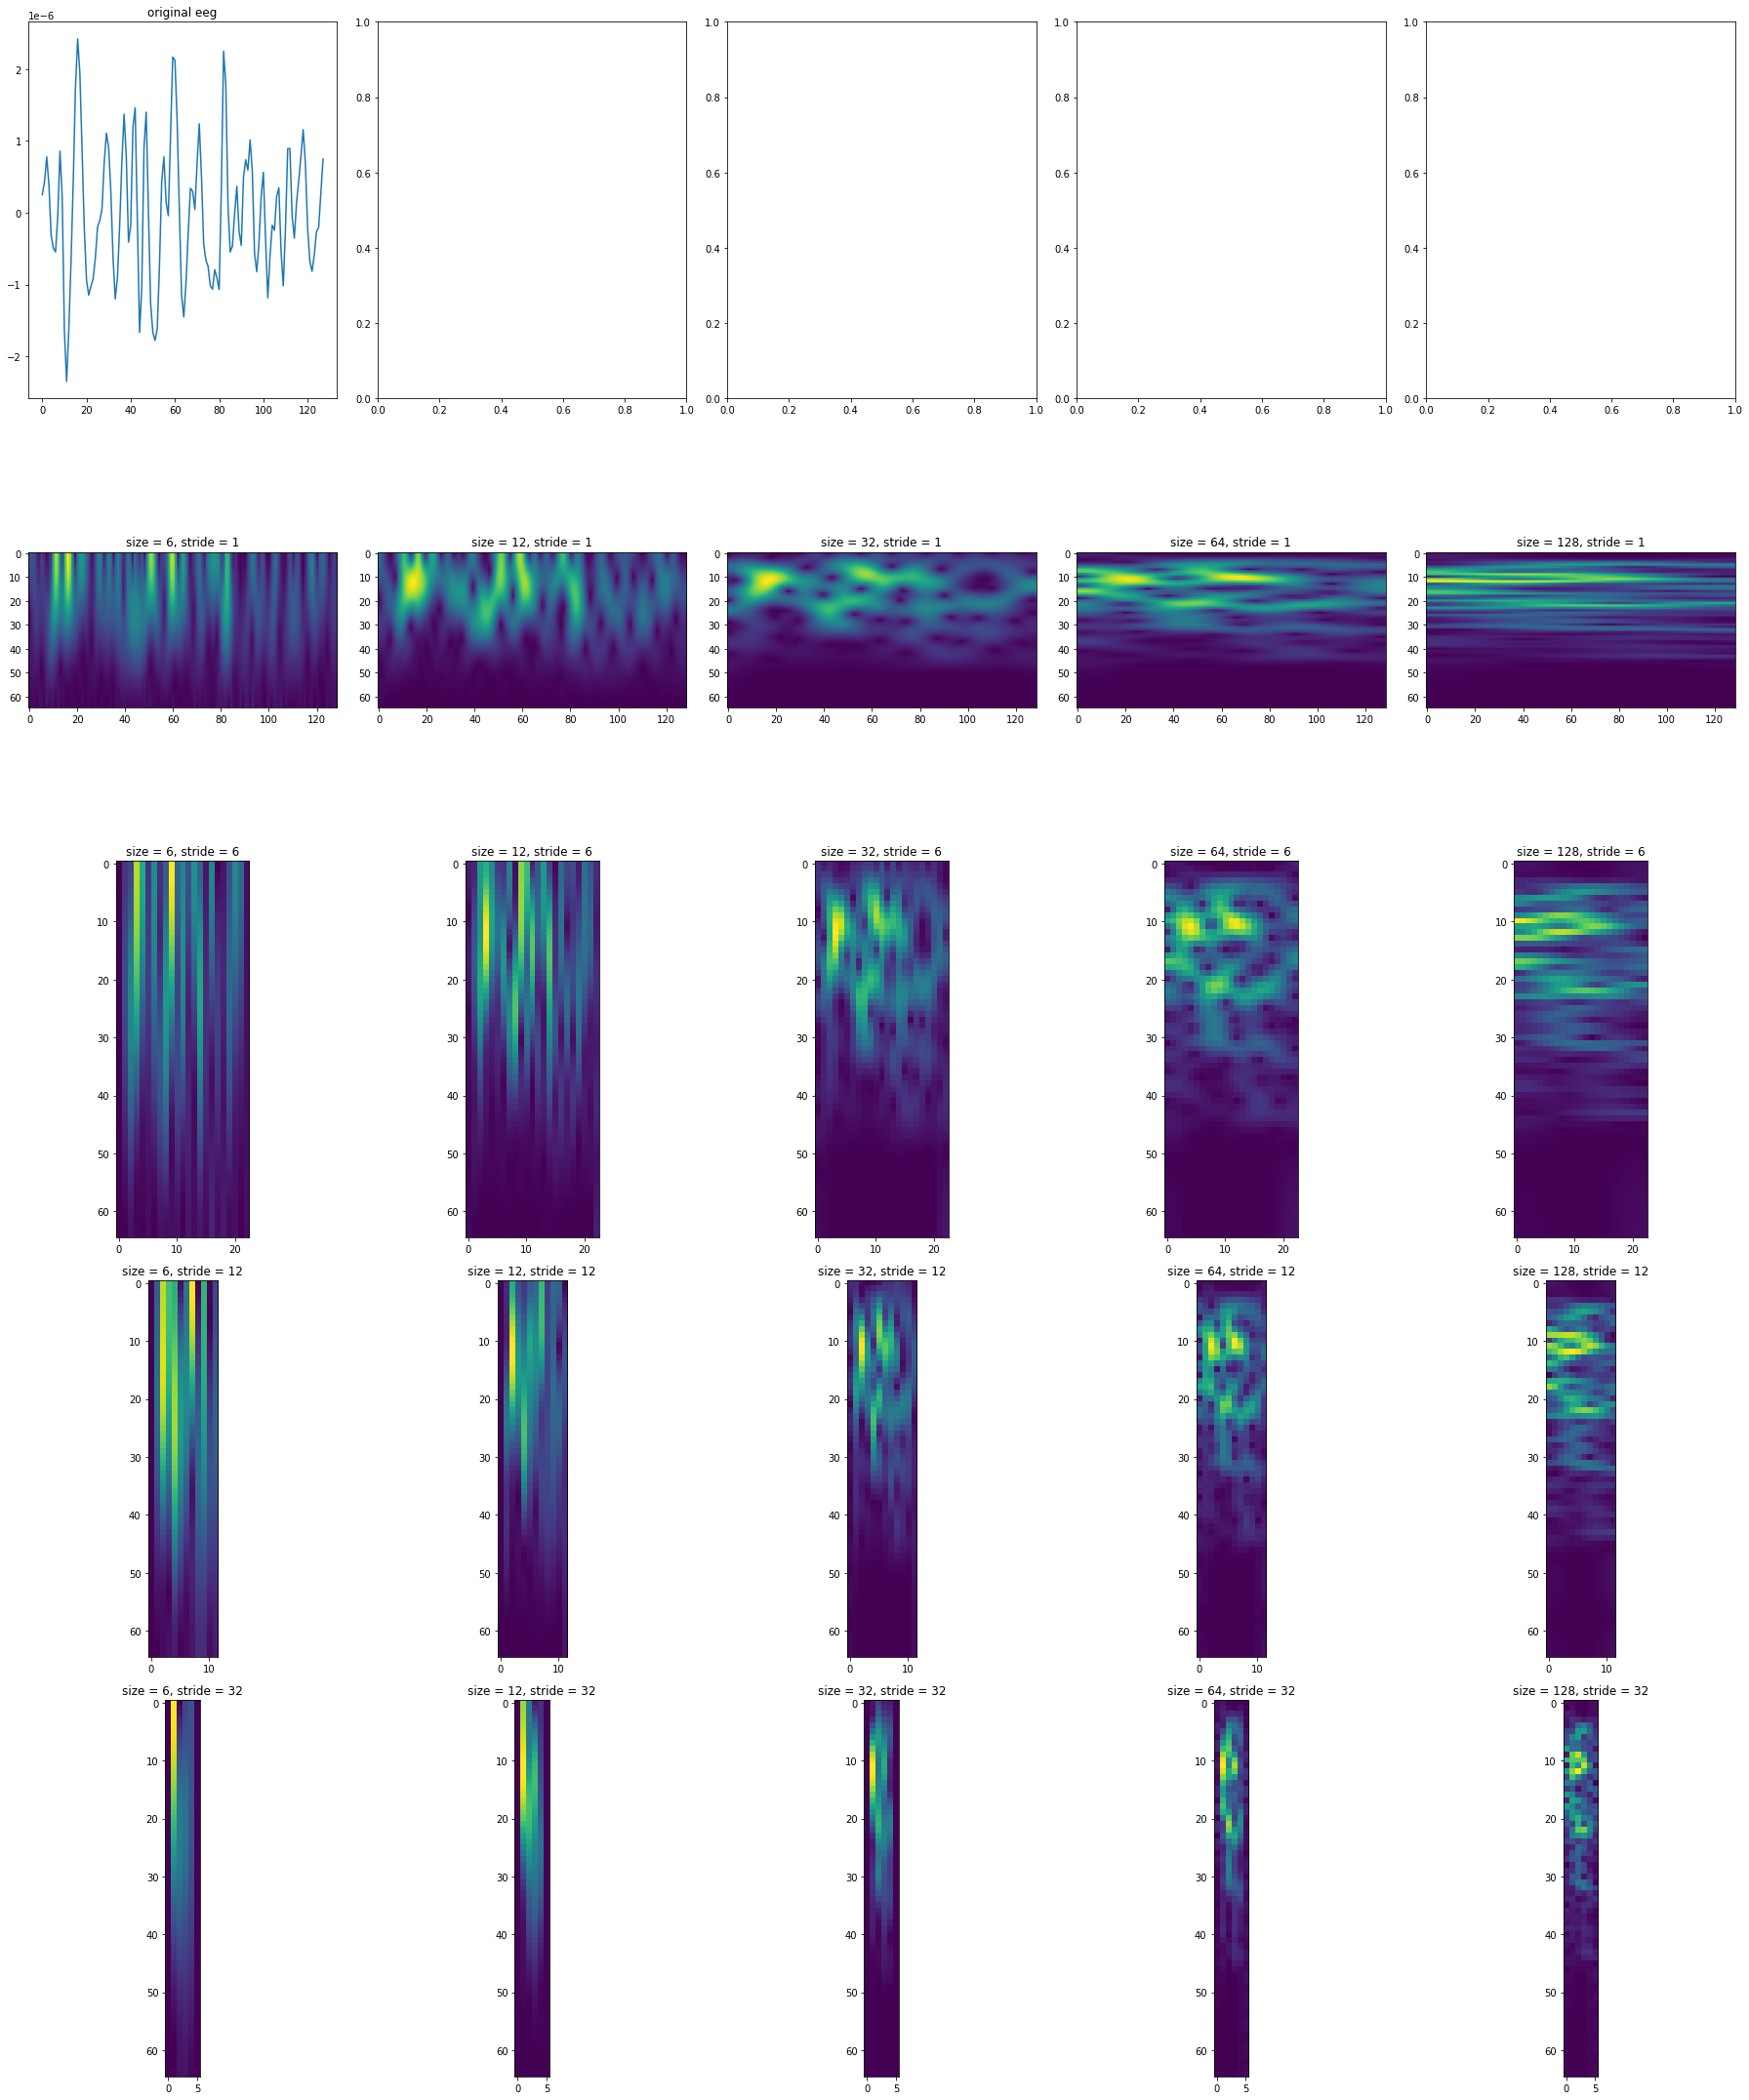

In [129]:
window_sizes = [0.05, 0.1, 0.25, 0.5, 1]
window_strides = [0.01, 0.05, 0.1, 0.25]
fig, axs = plt.subplots(nrows=len(window_strides)+1, ncols=len(window_sizes), tight_layout=True, figsize=(5*(len(window_strides)+1), 5*(len(window_sizes)+1)))
axs[0, 0].plot(sample[:, 0])
axs[0, 0].set_title("original eeg")
for i_size, window_size in enumerate(window_sizes):
    window_size = int(window_size * dataset.sampling_rate)
    for i_stride, window_stride in enumerate(window_strides):
        window_stride = int(window_stride * dataset.sampling_rate)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mel_fn = transforms.Spectrogram(
                # sample_rate=dataset.sampling_rate,
                # f_min=0, f_max=50,
                # n_mels=32,
                center=True,
                n_fft=128,
                normalized=False,
                power=1,
                win_length=window_size,
                hop_length=window_stride,
                pad=window_stride // 2,
                # pad=0,
            )
            spectrogram = mel_fn(sample[:, 0])  # (m s)
            # spectrogram = 20 * torch.log10(spectrogram/1e-5)
        axs[i_stride+1, i_size].imshow(spectrogram)
        axs[i_stride+1, i_size].set_title(f"size = {window_size}, stride = {window_stride}")
plt.show()

# Power

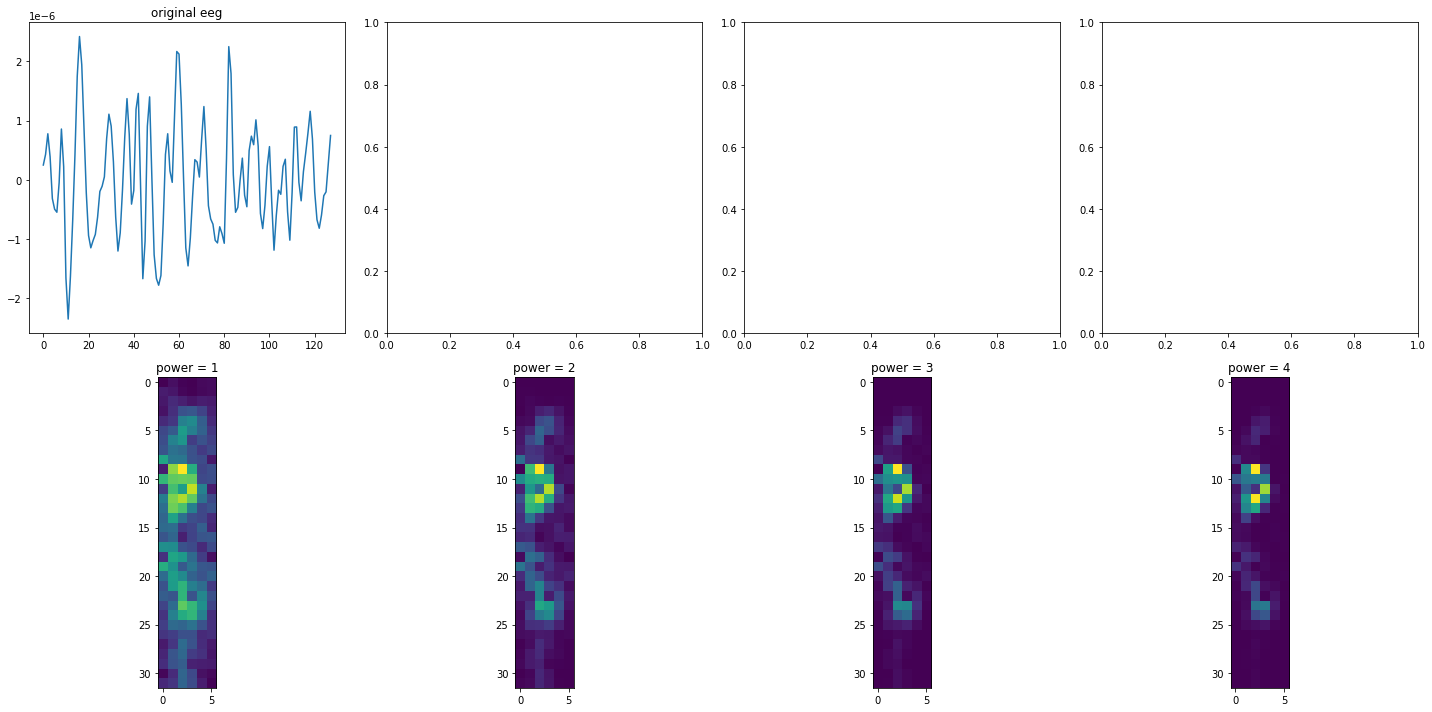

In [122]:
powers = [1, 2, 3, 4]
fig, axs = plt.subplots(nrows=2, ncols=len(powers), tight_layout=True, figsize=(5*len(powers), 5*2))
axs[0, 0].plot(sample[:, 0])
axs[0, 0].set_title("original eeg")
for i, power in enumerate(powers):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mel_fn = transforms.MelSpectrogram(
            sample_rate=dataset.sampling_rate,
            f_min=0, f_max=30,
            n_mels=32,
            center=True,
            n_fft=window_size,
            normalized=False,
            power=power,
            win_length=window_size,
            hop_length=window_stride,
            pad=window_stride // 2,
            # pad=0,
        )
        spectrogram = mel_fn(sample[:, 0])  # (m s)
    axs[1, i].imshow(spectrogram)
    axs[1, i].set_title(f"power = {power}")
plt.show()

# Number of FFT

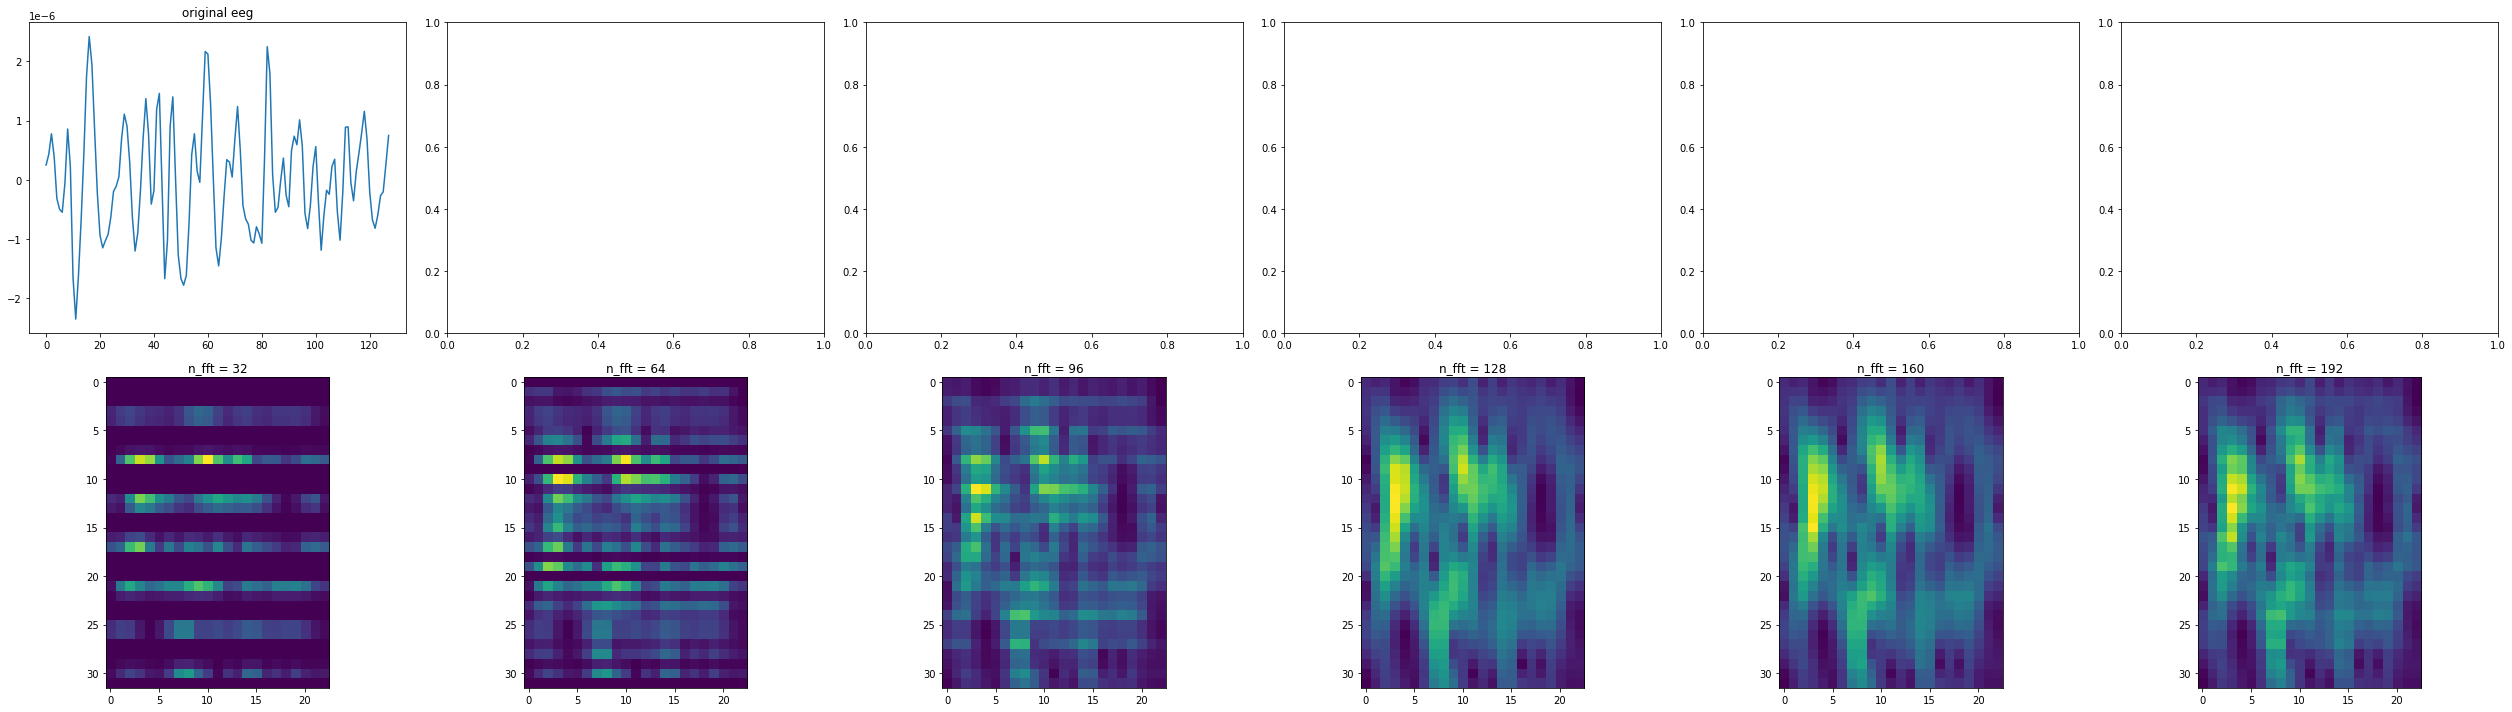

In [126]:
fft_multipliers = [1, 2, 3, 4, 5, 6]
window_size = int(dataset.sampling_rate * 0.25)
window_stride = int(dataset.sampling_rate * 0.05)
fig, axs = plt.subplots(nrows=2, ncols=len(fft_multipliers), tight_layout=True, figsize=(5*(len(fft_multipliers)+1), 5*2))
axs[0, 0].plot(sample[:, 0])
axs[0, 0].set_title("original eeg")
for i, fft_multiplier in enumerate(fft_multipliers):
    n_fft = int(window_size * fft_multiplier)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mel_fn = transforms.MelSpectrogram(
            sample_rate=dataset.sampling_rate,
            f_min=0, f_max=30,
            n_mels=32,
            center=True,
            n_fft=n_fft,
            normalized=False,
            power=1,
            win_length=window_size,
            hop_length=window_stride,
            pad=window_stride // 2,
            # pad=0,
        )
        spectrogram = mel_fn(sample[:, 0])  # (m s)
    axs[1, i].imshow(spectrogram)
    axs[1, i].set_title(f"n_fft = {n_fft}")
plt.show()